In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
import random
from functions import *
import seaborn as sns

metrics_dict = {}

# Import

The data from the EDA is imported and cleaned up a bit. The classification task that will be attempted is a binary classification task (Left vs. Right classified news articles). As such, the "Middle" category explored in the EDA is replaced with "Left," as the only middle publisher (Associated Press) is slightly left-leaning, strictly speaking according to the bias scores:

In [2]:
dframe = pd.read_csv("news_dataset_EDA.csv")

dframe["Leaning"] = dframe["Leaning"].map({"Middle" : "Left",
                                           "Left": "Left",
                                           "Right": "Right"})

dframe.drop("Leaning Encode", axis=1, inplace=True)

All data is re-encoded:

In [3]:
encode = []

for i in range(dframe.shape[0]):
    lean = dframe["Leaning"].iloc[i]
    if lean == "Left":
        encode.append(0)
    elif lean == "Right":
        encode.append(1)

dframe["Leaning Encode"] = pd.Series(encode)

Examining the data to ensure the encoding was done properly:

In [4]:
dframe.head()

,Source,Headline,Content,Date,Leaning,Headline Length,Content Length,Normalized Headline,Normalized Content,LDA_topics,NMF_topics,Headline Polarity,Content Polarity,Leaning Encode
0,Associated Press,"For Nebraska Rep. Fortenberry, a two-sided cha...","LINCOLN, Neb. -- When he seeks office again i...",11/15/21,Left,9,817,nebraska rep fortenberry two sided challenge 2022,lincoln neb seek office 2022 u rep jeff forten...,House/Senate,Trump,0.000000,0.072480,0
1,Associated Press,Former New Orleans mayor Landrieu to manage Bi...,WASHINGTON -- President Joe Biden has chosen ...,11/15/21,Left,10,295,former new orleans mayor landrieu manage biden...,washington president joe biden chosen supervis...,Inflation/Infrustructure,Inflation/Infrastructure,0.068182,0.115488,0
2,Associated Press,Alzheimer's drug cited as Medicare premium jum...,"WASHINGTON -- Medicare's ""Part B"" outpatient ...",11/15/21,Left,9,739,alzheimers drug cited medicare premium jump 2160,washington medicare part b outpatient premium ...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.031020,0
3,Associated Press,Buttigieg's star rises as $1T Biden agenda shi...,"WASHINGTON -- Pete Buttigieg, the transportat...",11/15/21,Left,10,1212,buttigiegs star rise 1t biden agenda shift toward,washington pete buttigieg transportation secre...,Inflation/Infrustructure,Inflation/Infrastructure,0.000000,0.147375,0
4,Associated Press,Inside DNC chair's 'challenging' bid to avert ...,He's not particularly close to the White House...,11/15/21,Left,9,2019,inside dnc chair challenging bid avert midterm...,he particularly close white house he never sta...,House/Senate,Trump,0.500000,0.055720,0


Any null data are removed:

In [5]:
dframe = dframe.dropna()

In [6]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1493 entries, 0 to 1493
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Source               1493 non-null   object 
 1   Headline             1493 non-null   object 
 2   Content              1493 non-null   object 
 3   Date                 1493 non-null   object 
 4   Leaning              1493 non-null   object 
 5   Headline Length      1493 non-null   int64  
 6   Content Length       1493 non-null   int64  
 7   Normalized Headline  1493 non-null   object 
 8   Normalized Content   1493 non-null   object 
 9   LDA_topics           1493 non-null   object 
 10  NMF_topics           1493 non-null   object 
 11  Headline Polarity    1493 non-null   float64
 12  Content Polarity     1493 non-null   float64
 13  Leaning Encode       1493 non-null   int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 175.0+ KB


A DeepCopy of the data is made for later use in 5-Fold Cross Validation.

In [7]:
df = copy.deepcopy(dframe)

# Machine Learning Models

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

Several machine learning models are explored for this project:

&bull; k-Nearest Neighbors <br>
&bull; Logistic Regression <br>
&bull; Support Vector Machines (with different kernels) <br>
&bull; Decision Trees <br>
&bull; Random Forest <br>

For a classifier to be "good" and providing acceptable classifications, it must outperform some basic baseline models. The baseline models explored herein are the Majority Vote classifier and the Coin Flip classifier. Both are discussed in the following sections.

## Test/Train Split and TF-IDF Vectorization

The total data is split into a test set and a train set. A test set size of 0.25 is used:

In [9]:
shuffled, test_data, y_test, train_data, y_train, test_df, train_df = test_train_split(dframe, test_size=0.25, content=True, random_state=19960402)

Both train and test documents are vectorized (TF-IDF vectorization) using the available funcitons from scikit-learn:

In [10]:
train_features = tfidfvectorizer.fit_transform(train_data).toarray()
test_features = tfidfvectorizer.transform(test_data).toarray()

## Baseline Models

Simple baseline models are selected to compare ML model results against in order to determine if ML models can actually better predict the data. For example, if an ML model has an accuracy of 30%, how can one say that it is better than simply picking classification label at random? Or, how can one say that it is better than simply classifying each point in the test set as the majority class from the train set?

### Majority Vote Classifier

The majority vote classifier is very straightforward. From the train data, the majority class is determined. Then, for each point in the test data, that same majority class is predicted:

In [11]:
train_df["Leaning Encode"].value_counts()

1    598
0    522
Name: Leaning Encode, dtype: int64

In this specifc test/train split, the majority class in the train set is 1, or right-leaning articles. For each point in the test set, the prediction is 1.

In [12]:
majority = train_df["Leaning Encode"].value_counts().sort_index(ascending=False).index[0]
y_pred = [majority]*test_df.shape[0]

Accuracy:  0.5335120643431636
Precision:  0.5335120643431636
Recall:  1.0
F1:  0.6958041958041957


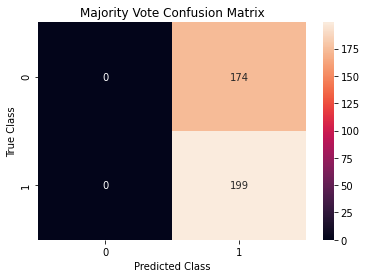

In [13]:
present_metrics(y_test, y_pred)
present_cfm(y_test, y_pred, title="Majority Vote Confusion Matrix")

Clearly, this approach is rudimentary at best; however, the key point is that it achieves an accuracy and precision greater than 50%. This baseline metric is important to compare to against ML models to substantiate that they are "better" than simple guesses.

#### 5-Fold Cross Validation

In 5-Fold Cross Validation, the total data is split into five folds. One fold is used as test data, while the remaining four folds are used as training data. This way, five different test/train splits are assessed and the average of the results provides a better look at the model's performance:

In [14]:
metrics = baseline_cross_validation(df=df, fold_count=5, repetitions=1, random_state=99)

In [15]:
print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

Mean Accuracy:  0.5338241565845885
Mean Precision:  0.5338241565845885
Mean Recall:  1.0
Mean F1:  0.6960144333897447


In [16]:
metrics_dict = metrics_dictionary(metrics_dict, "majority", metrics)

The majority vote classifier performance is just about 53%, looking at accuracy and precision solely.

### Coin Flip

The Coin Flip is another simple predictor model. Random numbers, either 0 or 1 (the leaning encodings), are generated from a uniform distribution and used as predictions for the test set:

In [17]:
np.random.seed(500)
y_pred = np.random.randint(low=0, high=2, size=test_df.shape[0])

Accuracy:  0.49865951742627346
Precision:  0.531578947368421
Recall:  0.507537688442211
F1:  0.519280205655527


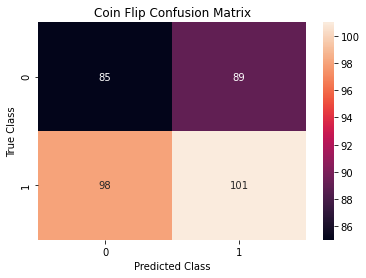

In [18]:
present_metrics(y_test, y_pred)
present_cfm(y_test, y_pred, title="Coin Flip Confusion Matrix")

All metrics are roughly 50%. No 5-fold cross validation is performed here as since the numbers are randomly generated from a uniform distribution, the metrics will be just about 50%.

### k-Nearest Neighbors

The first ML algorithm explored is k-Nearest Neighbors (kNN). This is a fairly simple "machine learning" algorithm, but it may prove useful.

#### Validation Curve

A validation curve is used to determine the best value for `k`, the neighborhood size. Values for `k` are varied from 1 to 20:

In [19]:
ks, accs, precs, recs, f1s = knn_validation_curve(train_features, test_features, y_train, y_test)

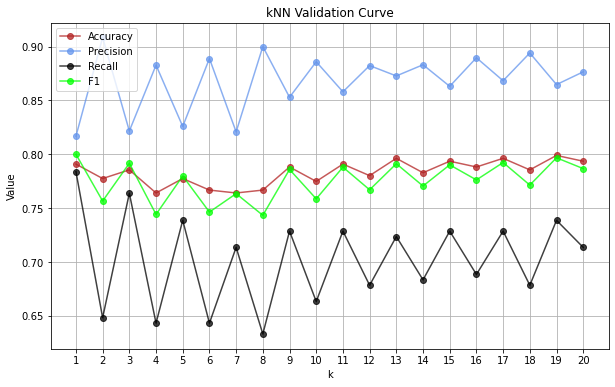

In [20]:
xs = ks
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, accs, "o-", color="firebrick", alpha=0.75, label = "Accuracy")
axes.plot(xs, precs, "o-", color="cornflowerblue", alpha=0.75, label = "Precision")
axes.plot(xs, recs, "o-", color="black", alpha=0.75, label = "Recall")
axes.plot(xs, f1s, "o-", color="lime", alpha=0.75, label = "F1")
axes.set_title("kNN Validation Curve")
axes.set_xlabel("k")
axes.set_ylabel("Value")
axes.legend()
plt.xticks(xs)
plt.grid(b=True, which="both")
plt.show()

The size of the neighborhood as an appreciable effect on all the classificaiton metrics. From personal experience, although it appears that a value of `k = 2` is best from a precision standpoint, `k` will be set to 1:

#### 5-Fold Cross Validation

In [21]:
clf = KNeighborsClassifier(n_neighbors=1)
metrics = kfold_cross_validation(clf=clf, df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

In [22]:
print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

Mean Accuracy:  0.9410406051491549
Mean Precision:  0.9571394287883148
Mean Recall:  0.9332313208370463
Mean F1:  0.944150228092121


In [23]:
metrics_dict = metrics_dictionary(metrics_dict, "knn", metrics)

The average metrics above show a vast improvement over the one test/train split shown previously.

### Logistic Regression

In [24]:
clf = LogisticRegression(random_state=42)
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

In [25]:
print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

Mean Accuracy:  0.9290049606069448
Mean Precision:  0.9285053383988592
Mean Recall:  0.9441540025795068
Mean F1:  0.9343547147551827


In [26]:
metrics_dict = metrics_dictionary(metrics_dict, "logreg", metrics)

### Support Vector Machine

#### RBF Kernel

In [27]:
clf = svm.SVC(kernel="rbf")
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "svm_rbf", metrics)

Mean Accuracy:  0.9611501425332765
Mean Precision:  0.9612979795793717
Mean Recall:  0.9684794494163395
Mean F1:  0.964002900610651


#### Linear Kernel

In [28]:
clf = svm.SVC(kernel="linear")
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "svm_linear", metrics)

Mean Accuracy:  0.9671746986599628
Mean Precision:  0.9728545964607449
Mean Recall:  0.967173208487457
Mean F1:  0.9694372811974947


#### Sigmoid Kernel

In [29]:
clf = svm.SVC(kernel="sigmoid")
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "svm_sigmoid", metrics)

Mean Accuracy:  0.9544454669928845
Mean Precision:  0.9638356536203864
Mean Recall:  0.9524093126565475
Mean F1:  0.9573291560761594


#### Poly = 3 Kernel

In [30]:
clf = svm.SVC(kernel="poly", degree=3)
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "svm_poly3", metrics)

Mean Accuracy:  0.9256380328163228
Mean Precision:  0.9238034982467129
Mean Recall:  0.9491394422103596
Mean F1:  0.9319714691226532


#### Poly = 5 Kernel

In [31]:
clf = svm.SVC(kernel="poly", degree=5)
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "svm_poly5", metrics)

Mean Accuracy:  0.8961504792260555
Mean Precision:  0.8893377722767596
Mean Recall:  0.9383749193768713
Mean F1:  0.904905551347742


### Decision Tree

In [32]:
clf = tree.DecisionTreeClassifier(random_state=0)
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "dt", metrics)

Mean Accuracy:  0.9691993445713901
Mean Precision:  0.9725044781551861
Mean Recall:  0.9699900836530635
Mean F1:  0.9708928060721451


### Random Forest

In [33]:
clf = RandomForestClassifier(random_state=0)
metrics = kfold_cross_validation(clf=clf,df=df, fold_count=5, repetitions=1, headline=False, content=True, random_state=400)

print("Mean Accuracy: ", np.mean(metrics[0]))
print("Mean Precision: ", np.mean(metrics[1]))
print("Mean Recall: ", np.mean(metrics[2]))
print("Mean F1: ", np.mean(metrics[3]))

metrics_dict = metrics_dictionary(metrics_dict, "rf", metrics)

Mean Accuracy:  0.971872685237144
Mean Precision:  0.9758043153744478
Mean Recall:  0.9734815715622483
Mean F1:  0.9739423637669591


# Model Metrics

In [35]:
print("Classification Metrics - Content Only - No Stemming")
summarize_metrics(metrics_dict)

Classification Metrics - Content Only - No Stemming
 Acc. Prec. Rec. F1
majority 0.5338 0.5338 1.0000 0.6960
knn 0.9410 0.9571 0.9332 0.9442
logreg 0.9290 0.9285 0.9442 0.9344
svm_rbf 0.9612 0.9613 0.9685 0.9640
svm_linear 0.9672 0.9729 0.9672 0.9694
svm_sigmoid 0.9544 0.9638 0.9524 0.9573
svm_poly3 0.9256 0.9238 0.9491 0.9320
svm_poly5 0.8962 0.8893 0.9384 0.9049
dt 0.9692 0.9725 0.9700 0.9709
rf 0.9719 0.9758 0.9735 0.9739
